In [5]:
!pip install nltk

     |████████████████████████████████| 1.5 MB 33.7 MB/s eta 0:00:01
     |████████████████████████████████| 303 kB 124.1 MB/s eta 0:00:01


In [6]:
import csv
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords

In [7]:
STOPWORDS = set(stopwords.words('english'))
vocab_size = 5000
embedding_dim = 64
max_length = 100
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

In [8]:

articles = []
labels = []

with open("testdata1.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[1])
        article = row[0]
#        for word in STOPWORDS:
#            token = ' ' + word + ' '
#            article = article.replace(token, ' ')
#            article = article.replace(' ', ' ')
        articles.append(article)

In [9]:
train_size = int(len(articles) * training_portion)

train_articles = articles[0: train_size]
train_labels = labels[0: train_size]

validation_articles = articles[train_size:]
validation_labels = labels[train_size:]
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index
dict(list(word_index.items())[0:10])

train_sequences = tokenizer.texts_to_sequences(train_articles)
print(train_sequences[10])

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
#print(len(train_sequences[0]))
#print(len(train_padded[0]))

#print(len(train_sequences[1]))
#print(len(train_padded[1]))

#print(len(train_sequences[10]))
#print(len(train_padded[10]))

validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

#print(len(validation_sequences))
#print(validation_padded.shape)

label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))
#print(training_label_seq[0])

[7, 10, 45, 92]


In [10]:
model = tf.keras.Sequential([
    # Add an Embedding layer expecting input vocab of size 5000, and output embedding dimension of size 64 we set at the top
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
#    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    # Add a Dense layer with 6 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(4, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          320000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 394,564
Trainable params: 394,564
Non-trainable params: 0
_________________________________________________________________


In [11]:
print(set(labels))

{'other', 'brakes', 'starter'}


In [12]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 10
history = model.fit(train_padded, training_label_seq, epochs=num_epochs,
                    validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/10
5/5 - 3s - loss: 1.3716 - accuracy: 0.3585 - val_loss: 1.3476 - val_accuracy: 0.4250
Epoch 2/10
5/5 - 0s - loss: 1.3242 - accuracy: 0.4717 - val_loss: 1.2867 - val_accuracy: 0.4250
Epoch 3/10
5/5 - 0s - loss: 1.2311 - accuracy: 0.4717 - val_loss: 1.1568 - val_accuracy: 0.4250
Epoch 4/10
5/5 - 0s - loss: 1.0925 - accuracy: 0.4717 - val_loss: 1.0970 - val_accuracy: 0.4250
Epoch 5/10
5/5 - 0s - loss: 1.0321 - accuracy: 0.4717 - val_loss: 1.0438 - val_accuracy: 0.4250
Epoch 6/10
5/5 - 0s - loss: 0.9961 - accuracy: 0.4969 - val_loss: 1.0211 - val_accuracy: 0.4250
Epoch 7/10
5/5 - 0s - loss: 0.9503 - accuracy: 0.5723 - val_loss: 0.9787 - val_accuracy: 0.4750
Epoch 8/10
5/5 - 0s - loss: 0.8704 - accuracy: 0.5786 - val_loss: 0.9168 - val_accuracy: 0.5250
Epoch 9/10
5/5 - 0s - loss: 0.7872 - accuracy: 0.6792 - val_loss: 0.8796 - val_accuracy: 0.4750
Epoch 10/10
5/5 - 0s - loss: 0.6947 - accuracy: 0.6981 - val_loss: 0.8200 - val_accuracy: 0.5750


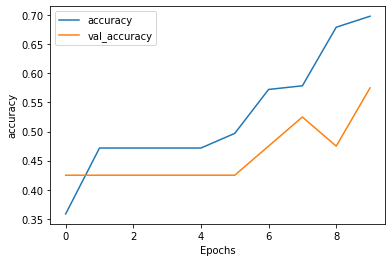

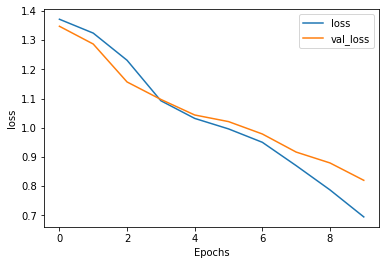

In [13]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()


plot_graphs(history, "accuracy")
plot_graphs(history, "loss")